In [1]:
!pip install category_encoders


In [52]:
pip install joblib


Note: you may need to restart the kernel to use updated packages.


## Import needed libraries

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.cm import get_cmap
from category_encoders import TargetEncoder
import category_encoders as ce
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector, SelectKBest, mutual_info_classif, chi2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import requests
import pickle
import joblib
import os
import warnings
warnings.filterwarnings('ignore')




## Function to plot all numerical features to check for the skewness  

In [3]:
def plot_skew(df):
    numerical_columns = df.select_dtypes(include=['number'])

    skewness = numerical_columns.skew()

    num_columns = len(numerical_columns.columns)
    num_plots_per_row = 4
    num_rows = (num_columns + num_plots_per_row - 1) // num_plots_per_row

    fig, axes = plt.subplots(num_rows, num_plots_per_row, figsize=(16, 4 * num_rows))

    for i, column in enumerate(numerical_columns.columns):
        row, col = divmod(i, num_plots_per_row)
        sns.histplot(numerical_columns[column], kde=True, ax=axes[row, col])
        axes[row, col].set_title(f"{column} (Skewness: {skewness[column]:.2f}")
        if row == num_rows - 1:
            axes[row, col].set_xlabel(column)
        else:
            axes[row, col].set_xlabel('')

    for j in range(i + 1, num_rows * num_plots_per_row):
        row, col = divmod(j, num_plots_per_row)
        fig.delaxes(axes[row, col])

    plt.tight_layout()
    plt.show()

## Function to pie plot the target column to check for the data balancing

In [4]:
# plot function to pie plot for the target value
def plot_pie(df, cols):
    for col in cols:
        plt.figure(figsize=(12,6))
        df[col].value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['red', 'green'], explode=(0.05, 0.05))
        plt.show()

## Function to use target encoder  

In [57]:
def target_encode(df, column, is_training_data=True):

  encoder = TargetEncoder(cols=[column])
    
  if is_training_data:
    encoder.fit(df, df['Target Attack'])
    
  df = encoder.transform(df)

  return df

## Function to use the sequential feature selection

In [6]:
def sequential_feature_selection(X, y, n_features_to_select):
  lr = LogisticRegression()
  sfs = SequentialFeatureSelector(estimator= lr , n_features_to_select=n_features_to_select)
  sfs.fit(X, y)
  selected_features = sfs.get_support()
  selected_feature_names = X.columns[selected_features]

  return selected_feature_names


## Functio to use the select best k features With the mutual information from the dataframe

In [7]:
def select_k_best_mi(X, y, k):
    
  skb = SelectKBest(mutual_info_classif, k=k)
  skb.fit(X, y)
  selected_features = skb.get_support()
  selected_feature_names = X.columns[selected_features]

  return selected_feature_names

## Function to use the select best k features With the chi2 from the dataframe

In [8]:
def select_k_best_chi2(X, y, k):
    skb = SelectKBest(chi2, k=k)
    skb.fit(X, y)
    selected_features = skb.get_support()
    selected_feature_names = X.columns[selected_features]

    return selected_feature_names

## Function to plot the accuracies depending on the selected features

In [9]:
def plot_accuracies_vs_feature_count(X, y, feature_selector , max_features):
    accuracies , feature_sets = [], []

    for num_features in range(2, max_features + 1):
        selected_features = feature_selector(X, y, num_features)
        
        X_selected = X[selected_features]
        feature_sets.append(X_selected)
        
        lr = LogisticRegression()
        lr.fit(X_selected, y)

        y_pred = lr.predict(X_selected)
        accuracy = accuracy_score(y, y_pred)
        accuracies.append(accuracy)
        
    max_accuracy_index = accuracies.index(max(accuracies))

    highest_accuracy = accuracies[max_accuracy_index]
    corresponding_features = feature_sets[max_accuracy_index]
    

    plt.figure(figsize=(10, 6))
    plt.plot(range(2, max_features + 1), accuracies, marker='o', linestyle='-', color='b')
    plt.title('Accuracy vs. Number of Selected Features')
    plt.xlabel('Number of Features')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()
    
    return corresponding_features

    

## Function for plotting the confusion matrix as heatmap

In [10]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=.5, cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Read Data

In [11]:
df = pd.read_csv('Static_dataset.csv')
df

,timestamp,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,longest_word,sld,len,subdomain,Target Attack
0,56:19.8,27,10,0,10,11,2.570417,6,6,7,3.666667,2,192,14,1,1
1,07:23.9,27,10,0,10,11,2.767195,6,6,7,3.666667,2,192,14,1,1
2,23:15.1,26,9,0,10,10,2.742338,6,6,7,3.500000,2,192,13,1,0
3,04:51.9,27,10,0,10,11,2.570417,6,6,7,3.666667,2,192,14,1,1
4,12:44.0,15,9,0,11,0,2.929439,4,3,5,4.333333,local,local,15,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268069,33:51.5,18,3,0,16,0,2.338623,2,3,10,5.333333,alma,almaalomah,14,1,0
268070,36:02.5,27,10,0,10,11,2.767195,6,6,7,3.666667,2,192,14,1,0
268071,37:21.5,27,10,0,10,11,2.767195,6,6,7,3.666667,2,192,14,1,1
268072,24:25.1,16,0,0,14,0,3.249687,2,2,13,7.500000,radio,radio-vintage,14,0,0


## checking for the data info

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268074 entries, 0 to 268073
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   timestamp         268074 non-null  object 
 1   FQDN_count        268074 non-null  int64  
 2   subdomain_length  268074 non-null  int64  
 3   upper             268074 non-null  int64  
 4   lower             268074 non-null  int64  
 5   numeric           268074 non-null  int64  
 6   entropy           268074 non-null  float64
 7   special           268074 non-null  int64  
 8   labels            268074 non-null  int64  
 9   labels_max        268074 non-null  int64  
 10  labels_average    268074 non-null  float64
 11  longest_word      268066 non-null  object 
 12  sld               268074 non-null  object 
 13  len               268074 non-null  int64  
 14  subdomain         268074 non-null  int64  
 15  Target Attack     268074 non-null  int64  
dtypes: float64(2), int64

## checking the numerical description of the data

In [13]:
df.describe()

,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,len,subdomain,Target Attack
count,268074.000000,268074.000000,268074.000000,268074.000000,268074.000000,268074.000000,268074.000000,268074.000000,268074.000000,268074.000000,268074.000000,268074.000000,268074.000000
mean,22.286596,6.059021,0.845420,10.410014,6.497586,2.485735,4.533577,4.788823,8.252233,4.802239,12.576714,0.753497,0.549024
std,6.001205,3.899505,4.941929,3.207725,4.499866,0.407709,2.187683,1.803256,4.415355,4.573066,4.177828,0.430975,0.497592
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.219195,0.000000,1.000000,2.000000,2.000000,2.000000,0.000000,0.000000
25%,18.000000,3.000000,0.000000,10.000000,0.000000,2.054029,2.000000,3.000000,7.000000,3.166667,11.000000,1.000000,0.000000
50%,24.000000,7.000000,0.000000,10.000000,8.000000,2.570417,6.000000,6.000000,7.000000,3.666667,12.000000,1.000000,1.000000
75%,27.000000,10.000000,0.000000,10.000000,10.000000,2.767195,6.000000,6.000000,7.000000,4.000000,14.000000,1.000000,1.000000
max,36.000000,23.000000,32.000000,34.000000,12.000000,4.216847,7.000000,7.000000,32.000000,32.000000,33.000000,1.000000,1.000000


## Checking for the null values

In [14]:
df.isna().sum()

timestamp           0
FQDN_count          0
subdomain_length    0
upper               0
lower               0
numeric             0
entropy             0
special             0
labels              0
labels_max          0
labels_average      0
longest_word        8
sld                 0
len                 0
subdomain           0
Target Attack       0
dtype: int64

## Checking for outliers

<AxesSubplot:>

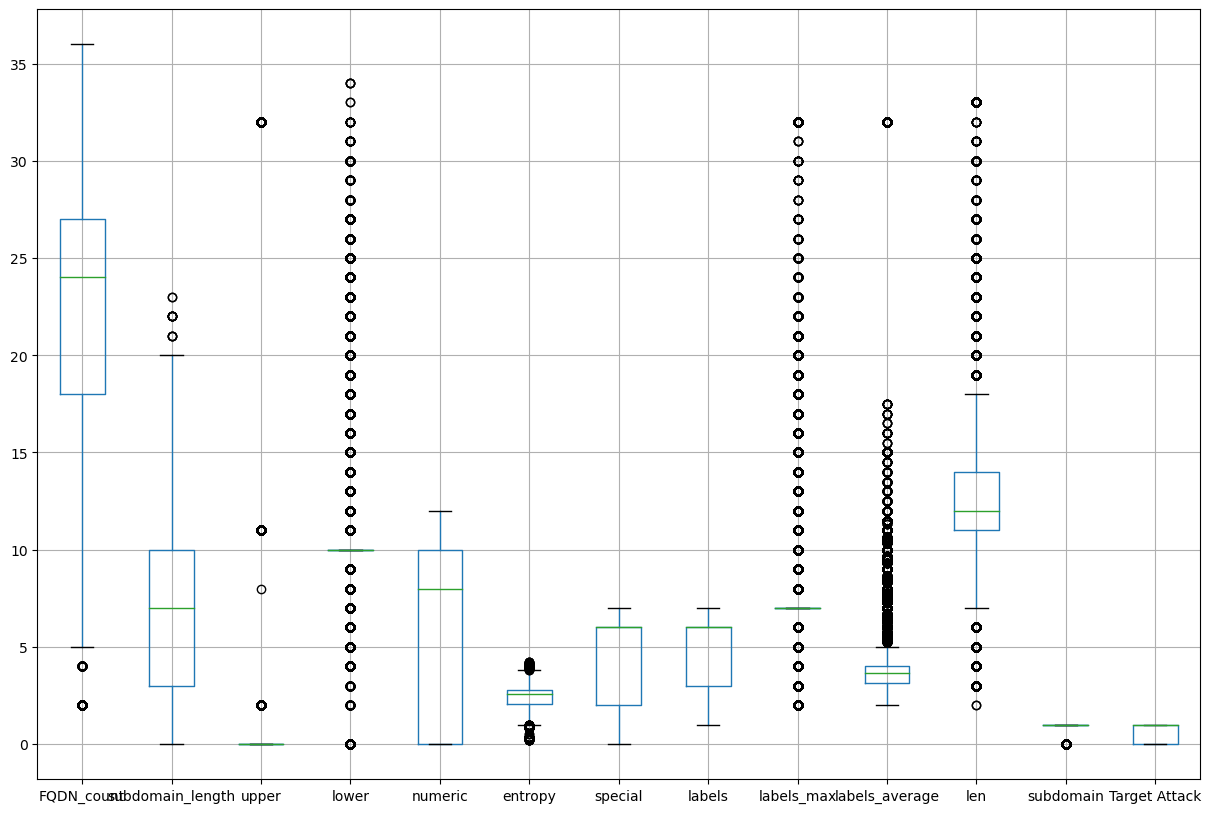

In [15]:
df.boxplot(figsize=(15,10))

## Chicking for the skewness

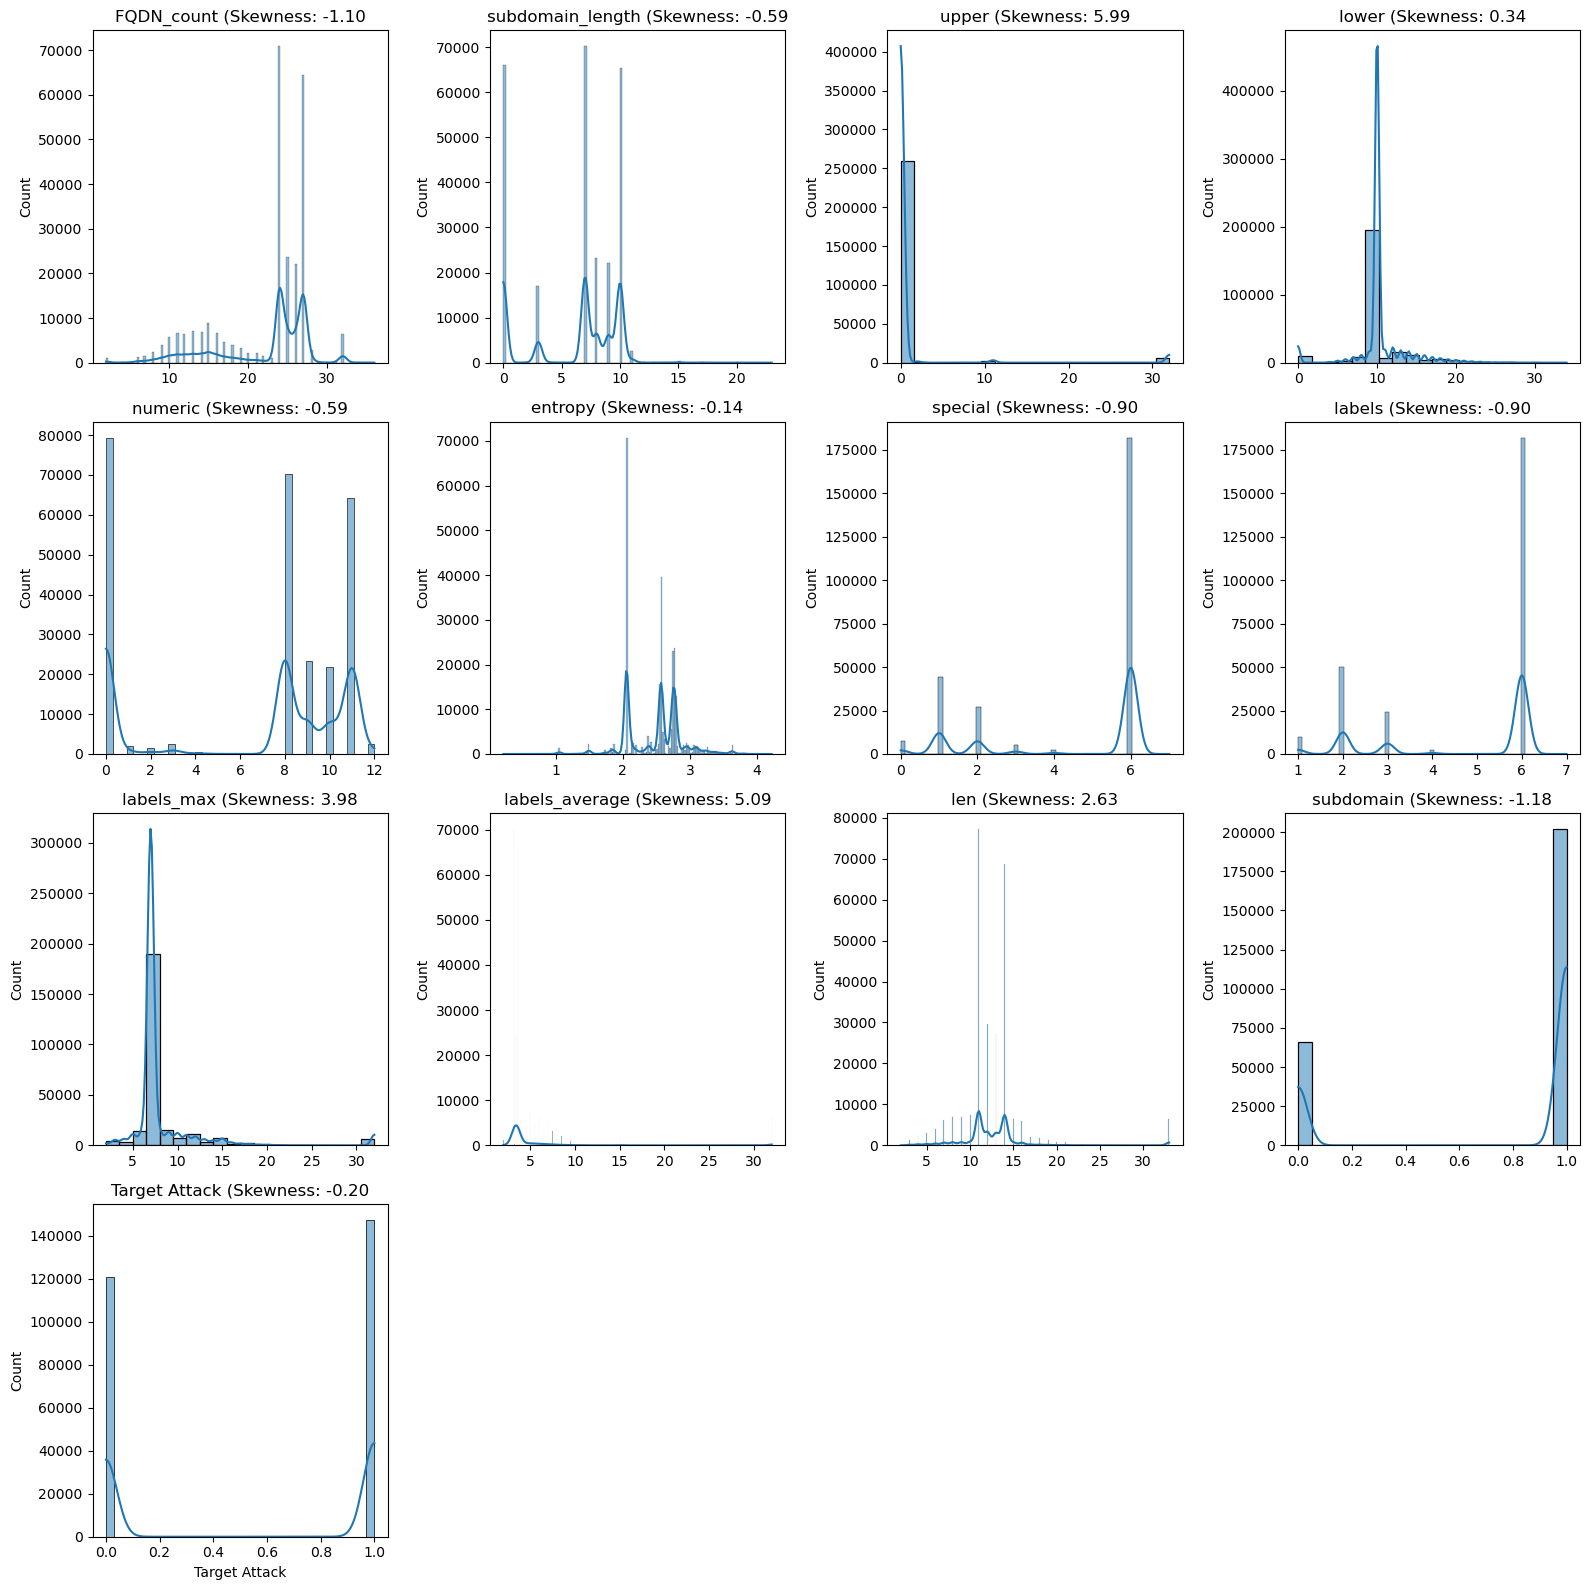

In [16]:
plot_skew(df)

In [17]:
df["longest_word"].value_counts()

2          109981
4           70188
N            4498
C            2969
9            1906
            ...  
yaa             1
queue           1
kit             1
airdrop         1
mal             1
Name: longest_word, Length: 6224, dtype: int64

In [18]:
df["sld"].value_counts()

192                                 109517
224                                  70188
FHEPFCELEHFCEPFFFACACACACACACABN      4498
DESKTOP-3JF04TC                       1961
239                                   1906
                                     ...  
freesgift                                1
secureserver                             1
airdropalert                             1
queue-it                                 1
lahemal                                  1
Name: sld, Length: 11112, dtype: int64

## Checking for the data balancing

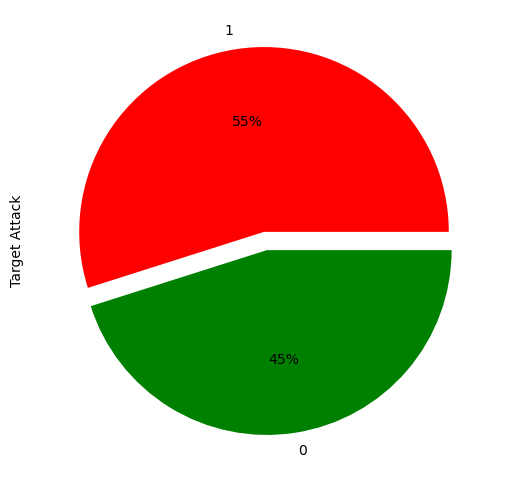

In [19]:
plot_pie(df, ['Target Attack'])

## Using Target Encoder for the object type columns

In [58]:
df = target_encode(df, 'sld')
df = target_encode(df, 'longest_word')
df

,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,longest_word,sld,len,subdomain,Target Attack
0,27,10,0,10,11,2.570417,6,6,7,3.666667,0.758813,0.759069,14,1,1
1,27,10,0,10,11,2.767195,6,6,7,3.666667,0.758813,0.759069,14,1,1
2,26,9,0,10,10,2.742338,6,6,7,3.500000,0.758813,0.759069,13,1,0
3,27,10,0,10,11,2.570417,6,6,7,3.666667,0.758813,0.759069,14,1,1
4,15,9,0,11,0,2.929439,4,3,5,4.333333,0.753954,0.755725,15,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268069,18,3,0,16,0,2.338623,2,3,10,5.333333,0.000000,0.000000,14,1,0
268070,27,10,0,10,11,2.767195,6,6,7,3.666667,0.758813,0.759069,14,1,0
268071,27,10,0,10,11,2.767195,6,6,7,3.666667,0.758813,0.759069,14,1,1
268072,16,0,0,14,0,3.249687,2,2,13,7.500000,0.000000,0.000000,14,0,0


## Checking for the data info after encoding

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268074 entries, 0 to 268073
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   timestamp         268074 non-null  object 
 1   FQDN_count        268074 non-null  int64  
 2   subdomain_length  268074 non-null  int64  
 3   upper             268074 non-null  int64  
 4   lower             268074 non-null  int64  
 5   numeric           268074 non-null  int64  
 6   entropy           268074 non-null  float64
 7   special           268074 non-null  int64  
 8   labels            268074 non-null  int64  
 9   labels_max        268074 non-null  int64  
 10  labels_average    268074 non-null  float64
 11  longest_word      268074 non-null  float64
 12  sld               268074 non-null  float64
 13  len               268074 non-null  int64  
 14  subdomain         268074 non-null  int64  
 15  Target Attack     268074 non-null  int64  
dtypes: float64(4), int64

## Dropping the timestamp column

In [22]:
df.drop(["timestamp"] , axis=1 , inplace=True)
df

,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,longest_word,sld,len,subdomain,Target Attack
0,27,10,0,10,11,2.570417,6,6,7,3.666667,0.758813,0.759069,14,1,1
1,27,10,0,10,11,2.767195,6,6,7,3.666667,0.758813,0.759069,14,1,1
2,26,9,0,10,10,2.742338,6,6,7,3.500000,0.758813,0.759069,13,1,0
3,27,10,0,10,11,2.570417,6,6,7,3.666667,0.758813,0.759069,14,1,1
4,15,9,0,11,0,2.929439,4,3,5,4.333333,0.753954,0.755725,15,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268069,18,3,0,16,0,2.338623,2,3,10,5.333333,0.354481,0.421938,14,1,0
268070,27,10,0,10,11,2.767195,6,6,7,3.666667,0.758813,0.759069,14,1,0
268071,27,10,0,10,11,2.767195,6,6,7,3.666667,0.758813,0.759069,14,1,1
268072,16,0,0,14,0,3.249687,2,2,13,7.500000,0.065445,0.421938,14,0,0


## Splitting the dataset into the X and Y

In [23]:
X = df.drop(["Target Attack"] , axis=1)
Y = df["Target Attack"]

## Using Sequential Feature Selection

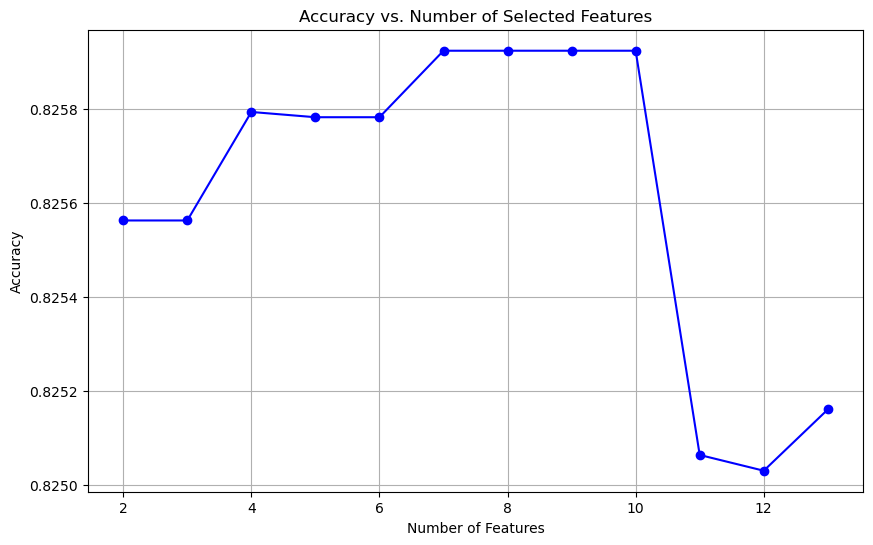

,FQDN_count,subdomain_length,lower,numeric,entropy,longest_word,sld
0,27,10,10,11,2.570417,0.758813,0.759069
1,27,10,10,11,2.767195,0.758813,0.759069
2,26,9,10,10,2.742338,0.758813,0.759069
3,27,10,10,11,2.570417,0.758813,0.759069
4,15,9,11,0,2.929439,0.753954,0.755725
...,...,...,...,...,...,...,...
268069,18,3,16,0,2.338623,0.354481,0.421938
268070,27,10,10,11,2.767195,0.758813,0.759069
268071,27,10,10,11,2.767195,0.758813,0.759069
268072,16,0,14,0,3.249687,0.065445,0.421938


In [24]:
sfs = plot_accuracies_vs_feature_count(X, Y, sequential_feature_selection , 13)
sfs

## Using SelectKBest with the mutual information

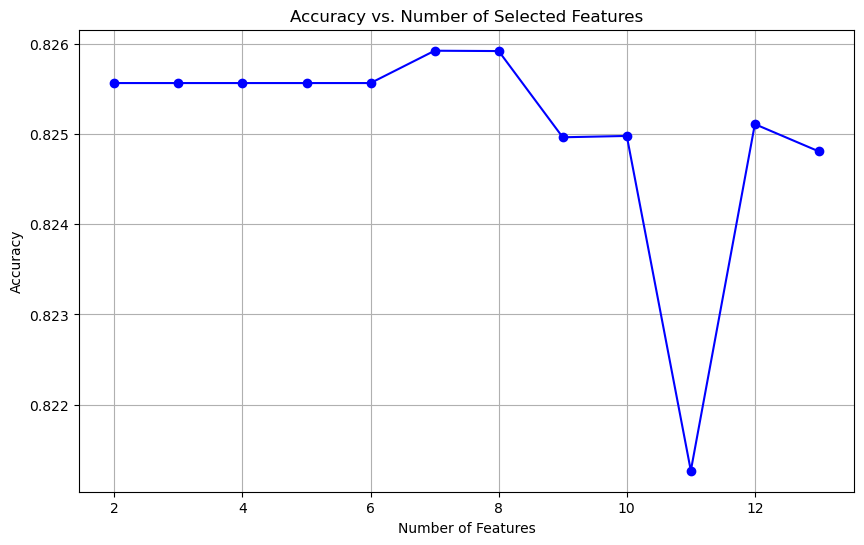

,FQDN_count,lower,entropy,special,labels,longest_word,sld
0,27,10,2.570417,6,6,0.758813,0.759069
1,27,10,2.767195,6,6,0.758813,0.759069
2,26,10,2.742338,6,6,0.758813,0.759069
3,27,10,2.570417,6,6,0.758813,0.759069
4,15,11,2.929439,4,3,0.753954,0.755725
...,...,...,...,...,...,...,...
268069,18,16,2.338623,2,3,0.354481,0.421938
268070,27,10,2.767195,6,6,0.758813,0.759069
268071,27,10,2.767195,6,6,0.758813,0.759069
268072,16,14,3.249687,2,2,0.065445,0.421938


In [25]:
skbm =  plot_accuracies_vs_feature_count(X, Y, select_k_best_mi , 13) 
skbm

## Using SelectKBest with the chi2

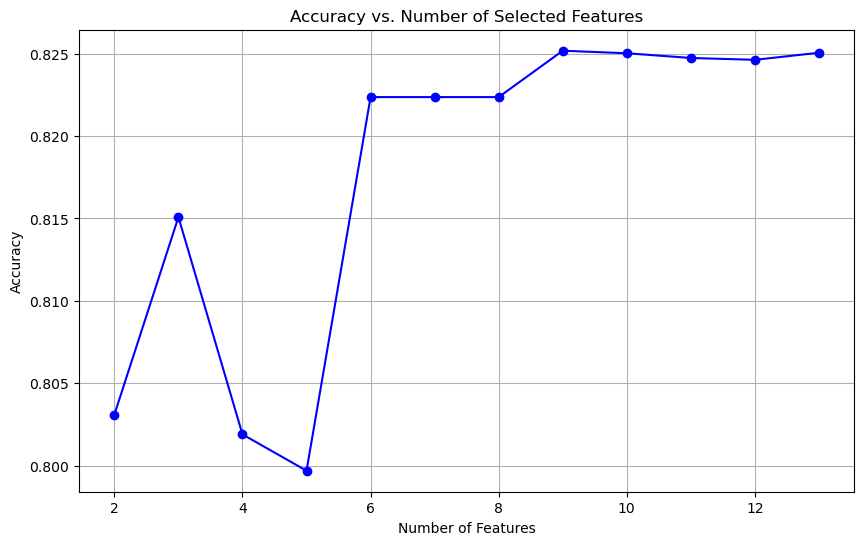

,FQDN_count,subdomain_length,upper,lower,numeric,special,labels,longest_word,subdomain
0,27,10,0,10,11,6,6,0.758813,1
1,27,10,0,10,11,6,6,0.758813,1
2,26,9,0,10,10,6,6,0.758813,1
3,27,10,0,10,11,6,6,0.758813,1
4,15,9,0,11,0,4,3,0.753954,1
...,...,...,...,...,...,...,...,...,...
268069,18,3,0,16,0,2,3,0.354481,1
268070,27,10,0,10,11,6,6,0.758813,1
268071,27,10,0,10,11,6,6,0.758813,1
268072,16,0,0,14,0,2,2,0.065445,0


In [26]:
skbc = plot_accuracies_vs_feature_count(X, Y, select_k_best_chi2 , 13) 
skbc

## Splitting the dataset into the Training set and Test set


In [27]:
X1 = sfs
X2 = skbm
X3 = skbc
Y = df["Target Attack"]

In [28]:
X_train1,X_test1,Y_train1,Y_test1 = train_test_split(X1,Y,test_size=0.3,random_state=42 , stratify=Y)
X_train2,X_test2,Y_train2,Y_test2 = train_test_split(X2,Y,test_size=0.3,random_state=42 , stratify=Y)
X_train3,X_test3,Y_train3,Y_test3 = train_test_split(X3,Y,test_size=0.3,random_state=42 , stratify=Y)


In [29]:
X_train1.shape, X_test1.shape, Y_train1.shape, Y_test1.shape


((187651, 7), (80423, 7), (187651,), (80423,))

## Scaling the data

In [30]:
scaler = StandardScaler()

X_train1 = scaler.fit_transform(X_train1)
X_test1 = scaler.transform(X_test1)

scaler = StandardScaler()

X_train2 = scaler.fit_transform(X_train2)
X_test2 = scaler.transform(X_test2)

scaler = StandardScaler()

X_train3 = scaler.fit_transform(X_train3)
X_test3 = scaler.transform(X_test3)

##  Logistic Regression

### Using Logistic Regression for the first dataset

In [31]:
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1],  
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200, 300]
}


lr_classifier = LogisticRegression(max_iter=10000)  

grid_search_lr = GridSearchCV(lr_classifier, param_grid_lr, scoring='precision')

grid_search_lr.fit(X_train1, Y_train1)

best_params_lr1 = grid_search_lr.best_params_
best_lr_model1 = grid_search_lr.best_estimator_

y_pred_lr1 = best_lr_model1.predict(X_test1)


Best Parameters for lr: {'C': 0.001, 'max_iter': 100, 'penalty': 'l2', 'solver': 'saga'}

Accuracy: 0.8256841948198899

Precision: 0.7597531332425397

Recall: 0.9981202156090049

F1 Score: 0.862775423106665

-----------------------------------------




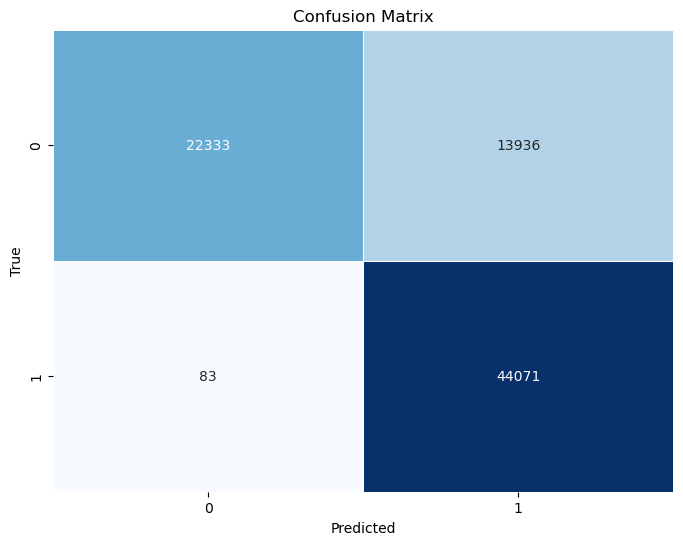

In [32]:
accuracy_lr1 = accuracy_score(Y_test1, y_pred_lr1)
precision_lr1 = precision_score(Y_test1, y_pred_lr1)
recall_lr1 = recall_score(Y_test1, y_pred_lr1)
f1_lr1 = f1_score(Y_test1, y_pred_lr1)

print("Best Parameters for lr:", best_params_lr1)
print()
print("Accuracy:", accuracy_lr1)
print()
print("Precision:", precision_lr1)
print()
print("Recall:", recall_lr1)
print()
print("F1 Score:", f1_lr1)
print()
print("-----------------------------------------")
print()
print()
plot_confusion_matrix(Y_test1, y_pred_lr1)

### Using Logistic Regression for the second dataset

In [33]:
grid_search_lr.fit(X_train2, Y_train2)

best_params_lr2 = grid_search_lr.best_params_
best_lr_model2 = grid_search_lr.best_estimator_

y_pred_lr2 = best_lr_model2.predict(X_test2)



Best Parameters for lr: {'C': 0.01, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}

Accuracy: 0.8256841948198899

Precision: 0.7597531332425397

Recall: 0.9981202156090049

F1 Score: 0.862775423106665

-----------------------------------------




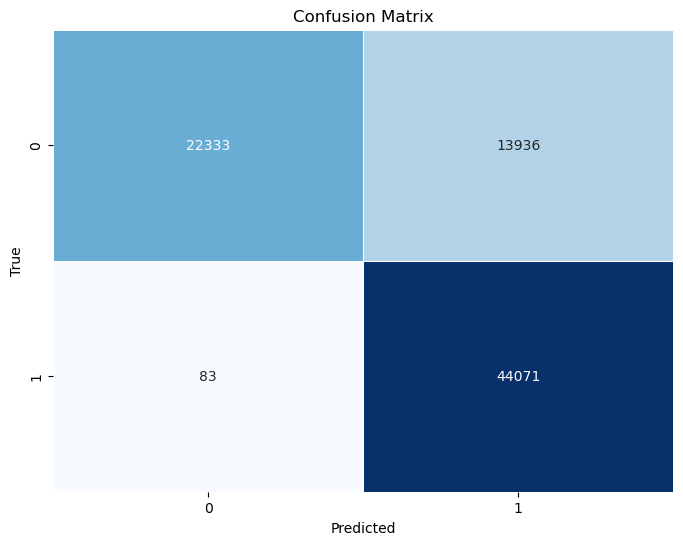

In [34]:
accuracy_lr2 = accuracy_score(Y_test2, y_pred_lr2)
precision_lr2 = precision_score(Y_test2, y_pred_lr2)
recall_lr2 = recall_score(Y_test2, y_pred_lr2)
f1_lr2 = f1_score(Y_test2, y_pred_lr2)

print("Best Parameters for lr:", best_params_lr2)
print()
print("Accuracy:", accuracy_lr2)
print()
print("Precision:", precision_lr2)
print()
print("Recall:", recall_lr2)
print()
print("F1 Score:", f1_lr2)
print()
print("-----------------------------------------")
print()
print()
plot_confusion_matrix(Y_test2, y_pred_lr2)

### Using Logistic Regression for the third dataset

In [35]:
grid_search_lr.fit(X_train3, Y_train3)

best_params_lr3 = grid_search_lr.best_params_
best_lr_model3 = grid_search_lr.best_estimator_

y_pred_lr3 = best_lr_model3.predict(X_test3)



Best Parameters for lr: {'C': 0.01, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}

Accuracy: 0.8251743904107034

Precision: 0.7595473833097596

Recall: 0.9972822394347058

F1 Score: 0.8623296255679148

-----------------------------------------




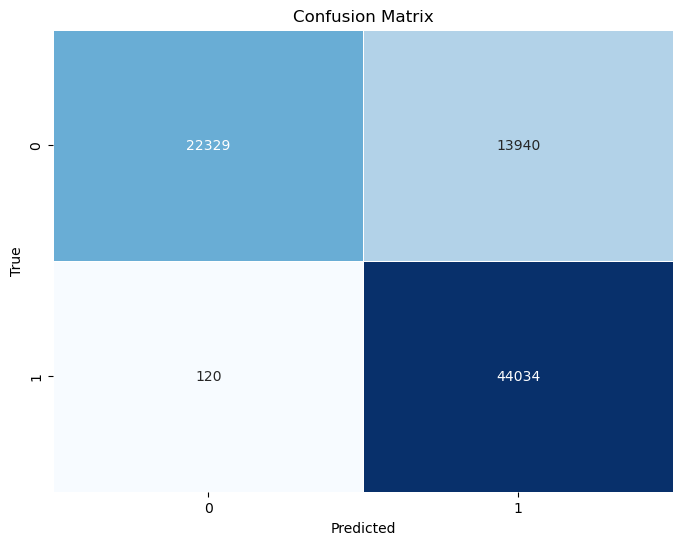

In [36]:
accuracy_lr3 = accuracy_score(Y_test3, y_pred_lr3)
precision_lr3 = precision_score(Y_test3, y_pred_lr3)
recall_lr3 = recall_score(Y_test3, y_pred_lr3)
f1_lr3 = f1_score(Y_test3, y_pred_lr3)

print("Best Parameters for lr:", best_params_lr3)
print()
print("Accuracy:", accuracy_lr3)
print()
print("Precision:", precision_lr3)
print()
print("Recall:", recall_lr3)
print()
print("F1 Score:", f1_lr3)
print()
print("-----------------------------------------")
print()
print()
plot_confusion_matrix(Y_test3, y_pred_lr3)

##  Random Forest

### Using Random Forest for the first dataset

In [37]:
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'max_features': ['auto', 'sqrt', 'log2']
}


random_forest = RandomForestClassifier()

grid_search_rf = GridSearchCV(random_forest, param_grid_rf, scoring='precision')

grid_search_rf.fit(X_train1, Y_train1)

best_params_rf1 = grid_search_rf.best_params_
best_rf_model1 = grid_search_rf.best_estimator_

y_pred_rf1 = best_rf_model1.predict(X_test1)

Best Parameters for Random Forest: {'max_depth': None, 'max_features': 'log2', 'n_estimators': 300}

Accuracy: 0.8262686047523718

Precision: 0.7597507659471927

Recall: 0.999682927934049

F1 Score: 0.8633571959472675

-----------------------------------------




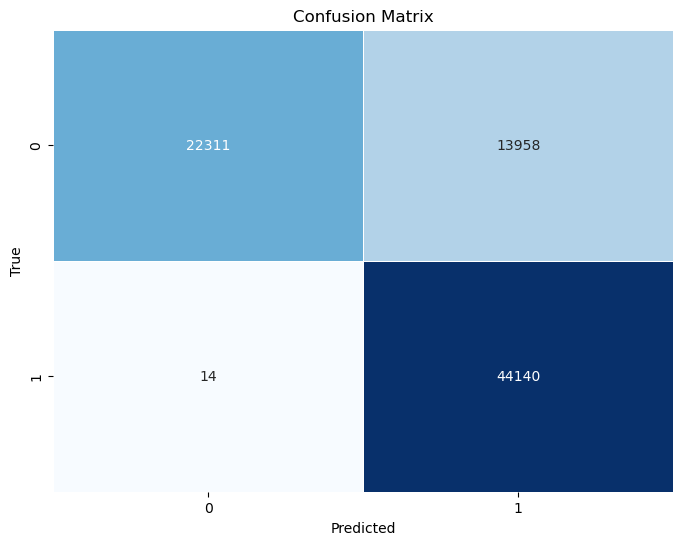

In [38]:
accuracy_rf1 = accuracy_score(Y_test1, y_pred_rf1)
precision_rf1 = precision_score(Y_test1, y_pred_rf1)
recall_rf1 = recall_score(Y_test1, y_pred_rf1)
f1_rf1 = f1_score(Y_test1, y_pred_rf1)

print("Best Parameters for Random Forest:", best_params_rf1)
print()
print("Accuracy:", accuracy_rf1)
print()
print("Precision:", precision_rf1)
print()
print("Recall:", recall_rf1)
print()
print("F1 Score:", f1_rf1)
print()
print("-----------------------------------------")
print()
print()
plot_confusion_matrix(Y_test1, y_pred_rf1)

### Using Random Forest for the second dataset

In [39]:
grid_search_rf.fit(X_train2, Y_train2)

best_params_rf2 = grid_search_rf.best_params_
best_rf_model2 = grid_search_rf.best_estimator_

y_pred_rf2 = best_rf_model2.predict(X_test2)

Best Parameters for Random Forest: {'max_depth': 20, 'max_features': 'auto', 'n_estimators': 300}

Accuracy: 0.8262810390062544

Precision: 0.7597549011170588

Recall: 0.9997055759387597

F1 Score: 0.8633683119321681

-----------------------------------------




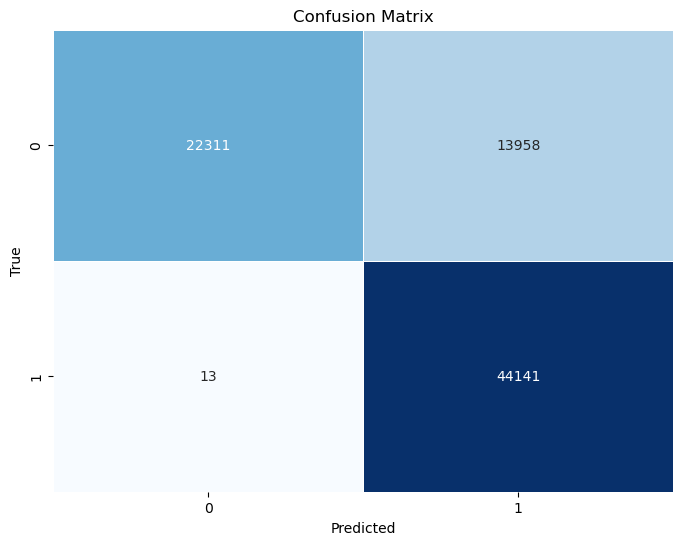

In [40]:
accuracy_rf2 = accuracy_score(Y_test2, y_pred_rf2)
precision_rf2 = precision_score(Y_test2, y_pred_rf2)
recall_rf2 = recall_score(Y_test2, y_pred_rf2)
f1_rf2 = f1_score(Y_test2, y_pred_rf2)

print("Best Parameters for Random Forest:", best_params_rf2)
print()
print("Accuracy:", accuracy_rf2)
print()
print("Precision:", precision_rf2)
print()
print("Recall:", recall_rf2)
print()
print("F1 Score:", f1_rf2)
print()
print("-----------------------------------------")
print()
print()
plot_confusion_matrix(Y_test2, y_pred_rf2)

### Using Random Forest for the third dataset

In [41]:
grid_search_rf.fit(X_train3, Y_train3)

best_params_rf3 = grid_search_rf.best_params_
best_rf_model3 = grid_search_rf.best_estimator_

y_pred_rf3 = best_rf_model3.predict(X_test3)

Best Parameters for Random Forest: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}

Accuracy: 0.8263307760217848

Precision: 0.7597535580911078

Recall: 0.9998414639670246

F1 Score: 0.8634181163884571

-----------------------------------------




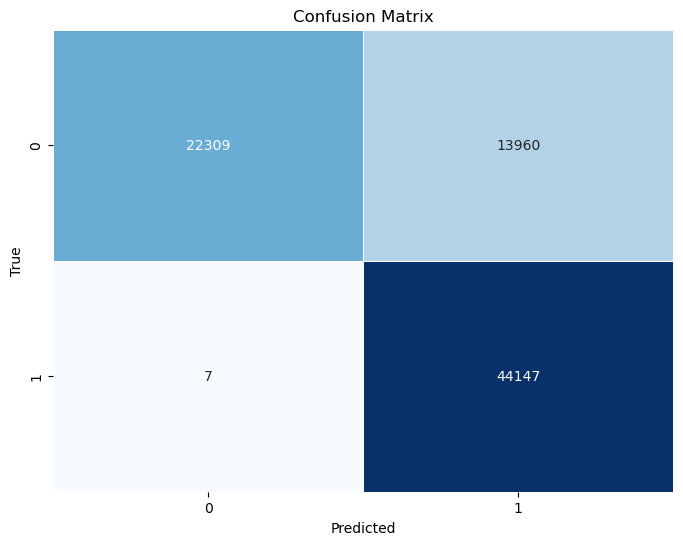

In [42]:
accuracy_rf3 = accuracy_score(Y_test3, y_pred_rf3)
precision_rf3 = precision_score(Y_test3, y_pred_rf3)
recall_rf3 = recall_score(Y_test3, y_pred_rf3)
f1_rf3 = f1_score(Y_test3, y_pred_rf3)

print("Best Parameters for Random Forest:", best_params_rf3)
print()
print("Accuracy:", accuracy_rf3)
print()
print("Precision:", precision_rf3)
print()
print("Recall:", recall_rf3)
print()
print("F1 Score:", f1_rf3)
print()
print("-----------------------------------------")
print()
print()
plot_confusion_matrix(Y_test3, y_pred_rf3)

## Plotting the results

In [43]:
acc = [accuracy_lr1, accuracy_lr2 , accuracy_lr3 , accuracy_rf1, accuracy_rf2 , accuracy_rf3]
prec = [precision_lr1, precision_lr2 , precision_lr3 , precision_rf1, precision_rf2 , precision_rf3]
rec = [recall_lr1, recall_lr2 , recall_lr3 , recall_rf1, recall_rf2 , recall_rf3]
f1 = [f1_lr1, f1_lr2 , f1_lr3 ,f1_rf1, f1_rf2 , f1_rf3]

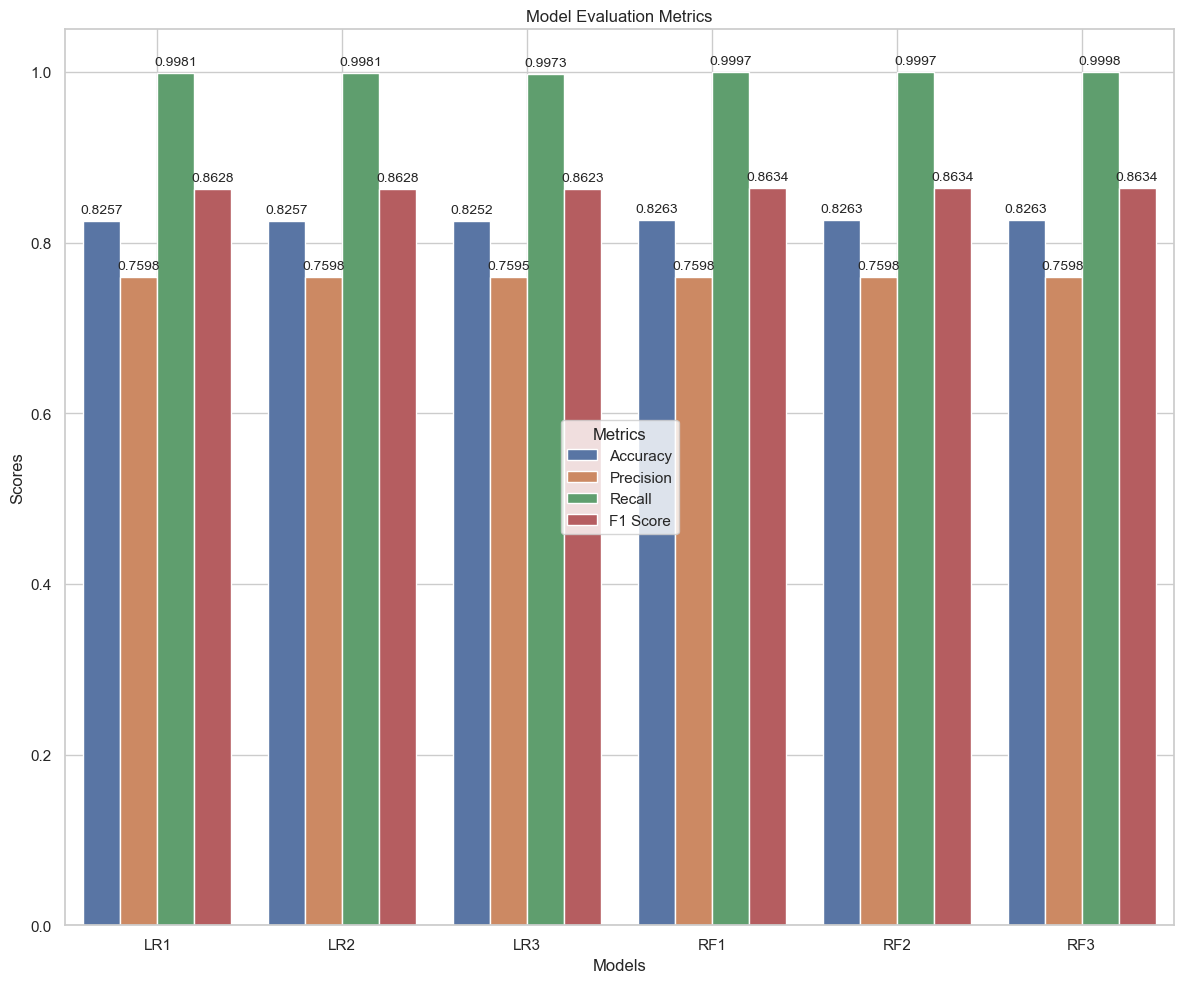

In [44]:
models = ['LR1', 'LR2', 'LR3', 'RF1', 'RF2', 'RF3']

# Create a DataFrame from the data

data = pd.DataFrame({'Model': models * 4,
                     'Metric': ['Accuracy'] * 6 + ['Precision'] * 6 + ['Recall'] * 6 + ['F1 Score'] * 6,
                     'Score': acc + prec + rec + f1})

plt.figure(figsize=(12, 10))
sns.set(style="whitegrid")
ax = sns.barplot(data=data, x="Model", y="Score", hue="Metric")
plt.title('Model Evaluation Metrics')
plt.xlabel('Models')
plt.ylabel('Scores')
plt.legend(title='Metrics' , loc = "center")
plt.grid(True)

# Add numbers on the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.4f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                size=10,
                xytext=(0, 8), 
                textcoords='offset points')

# Show the plot
plt.tight_layout()
plt.show()

### Saving the model

In [47]:
skbc

,FQDN_count,subdomain_length,upper,lower,numeric,special,labels,longest_word,subdomain
0,27,10,0,10,11,6,6,0.758813,1
1,27,10,0,10,11,6,6,0.758813,1
2,26,9,0,10,10,6,6,0.758813,1
3,27,10,0,10,11,6,6,0.758813,1
4,15,9,0,11,0,4,3,0.753954,1
...,...,...,...,...,...,...,...,...,...
268069,18,3,0,16,0,2,3,0.354481,1
268070,27,10,0,10,11,6,6,0.758813,1
268071,27,10,0,10,11,6,6,0.758813,1
268072,16,0,0,14,0,2,2,0.065445,0


In [48]:
best_params_rf3

{'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}

In [50]:
with open('Best_model.pkl', 'wb') as model_file:
    pickle.dump(best_rf_model3, model_file)

In [56]:
 joblib.dump(scaler, 'Scaler.pkl')

['Scaler.pkl']